In [2]:
!pip install torch accelerate transformers safetensors diffusers opencv-python pillow  mediapipe controlnet_aux



ERROR: Could not find a version that satisfies the requirement mediapipe (from versions: none)
ERROR: No matching distribution found for mediapipe


sk_model.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

sk_model2.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

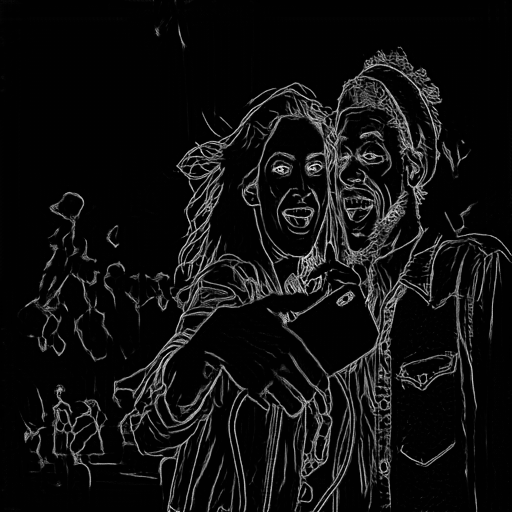

In [6]:
# from controlnet_aux import MidasDetector
# from PIL import Image
# import numpy as np

# # Load and prepare the input image
# input_image = Image.open("selfie.jpg").convert("RGB").resize((1024, 1024))

# # Use MidasDetector (automatically loads pretrained model)
# depth_estimator = MidasDetector.from_pretrained("lllyasviel/ControlNet")
# depth_map = depth_estimator(input_image)

# # Normalize the depth map to 8-bit and convert to RGB
# depth_np = np.array(depth_map)
# depth_np = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min())
# depth_map_img = Image.fromarray((depth_np * 255).astype(np.uint8)).convert("RGB")

# # Show or save the depth map image
# depth_map_img.save("depth_map.png")
# display(depth_map_img)

from controlnet_aux import LineartDetector
from PIL import Image

# Load and prepare the input image
input_image = Image.open("selfie.jpg").convert("RGB").resize((1024, 1024))

# Initialize the LineartDetector (downloads pretrained model if needed)
lineart_detector = LineartDetector.from_pretrained("lllyasviel/Annotators")

# Generate the lineart map from the input image
lineart_map = lineart_detector(input_image)

# Save and display the lineart image
lineart_map.save("lineart_map.png")
display(lineart_map)






In [2]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
import torch


# Charger ControlNet adapté à la depth map
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    torch_dtype=torch.float32  # float16 possible sur certains GPU
).to("mps")

# Charger le VAE optimisé pour SDXL (optionnel mais recommandé)
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float32
).to("mps")

# Charger le pipeline SDXL avec ControlNet
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float32
).to("mps")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
from diffusers.utils import load_image

ip_adapter_image = load_image("popart.jpeg")

In [11]:

!pip install -U peft transformers


In [9]:
!pip install insightface onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 10.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [onnxruntime] [onnxruntime]


In [9]:
# Make sure you have the right weights
!mkdir -p ip-adapter-faceid
!curl -L https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid-plusv2_sdxl.bin \
-o ip-adapter-faceid/ip-adapter-faceid-plusv2_sdxl.bin

!curl -L https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid-plusv2_sdxl_lora.safetensors \
-o ip-adapter-faceid/ip-adapter-faceid-plusv2_sdxl_lora.safetensors

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1225  100  1225    0     0   5501      0 --:--:-- --:--:-- --:--:--  5518
100 1418M  100 1418M    0     0  11.3M      0  0:02:05  0:02:05 --:--:-- 12.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1168  100  1168    0     0   4111      0 --:--:-- --:--:-- --:--:--  4098
100  354M  100  354M    0     0  11.2M      0  0:00:31  0:00:31 --:--:-- 11.0M


In [8]:
# pipe.unload_ip_adapter()
# pipe.load_ip_adapter(
#     "h94/IP-Adapter",  # ✅ this is a full adapter model
#     subfolder="sdxl_models",
#     weight_name="ip-adapter_sdxl.bin"
# )

# pipe.load_lora_weights(
#     "./ip-adapter-faceid",
#     weight_name="ip-adapter-faceid-plusv2_sdxl_lora.safetensors"
# )
pipe.load_ip_adapter(
    "h94/IP-Adapter",  # Loads the default style adapter
    subfolder="sdxl_models",
    weight_name="ip-adapter_sdxl.bin"
)


In [10]:
# Verify CLIP vision encoder is loaded
print("CLIP vision encoder:", pipe.image_encoder)
print("Feature extractor:", pipe.feature_extractor)

CLIP vision encoder: CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1664)
    )
    (pre_layrnorm): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-47): 48 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (v_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (q_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (out_proj): Linear(in_features=1664, out_features=1664, bias=True)
          )
          (layer_norm1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=

In [10]:
prompt = "apply a theme of pop art style to this image. Keep the same structure and dont displace its components"
result = pipe(
    prompt=prompt,
    image=input_image,
    control_image=lineart_map,
    ip_adapter_image=input_image,  
    # ip_adapter_scale=0.5,
    strength=0.75,
    num_inference_steps=20,
    controlnet_conditioning_scale=0.65
).images[0]
result.save("output.png")
results.show()

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'results' is not defined